In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

sns.set_style('whitegrid')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pymc3 as pm
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
import patsy

In [2]:
test_a = pd.read_csv("Test A.csv")

In [3]:
test_b = pd.read_csv( 'test B.csv')

In [4]:
test_b.columns = ["timestamp", "selection"]

In [5]:
test_a.columns = ["timestamp", "selection"]

In [6]:
print test_b['selection'].value_counts()
print test_a['selection'].value_counts()

The grey button     20
The green button     1
Name: selection, dtype: int64
The gray one     15
The green one     2
Name: selection, dtype: int64


In [7]:
le = LabelEncoder()

In [8]:
test_a["arm"] = 'A'

In [9]:
test_b["arm"] = 'B'

In [10]:
def func(aa):
    if aa == 1:
        return 0
    else:
        return 1 
   

In [11]:
test_a["selection"] = le.fit_transform(test_a["selection"])
test_b["selection"] = le.fit_transform(test_b["selection"])


In [12]:
test_a["selection"] = test_a["selection"].apply(func)


In [18]:
test_b["selection"] = test_b["selection"].apply(func)

In [19]:
test_b["selection"]

0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
15    1
16    1
17    1
18    1
19    0
20    1
Name: selection, dtype: int64

In [21]:
test_a.head()

,timestamp,selection,arm
0,2016/10/28 1:38:00 PM MDT,1,A
1,2016/10/28 1:40:23 PM MDT,1,A
2,2016/10/28 1:40:28 PM MDT,1,A
3,2016/10/28 1:40:30 PM MDT,1,A
4,2016/10/28 1:40:46 PM MDT,1,A


In [22]:
data = pd.concat((test_b, test_a), ignore_index=True)

In [23]:
data.rename(columns = {'selection': 'converted'}, inplace = True)
data

,timestamp,converted,arm
0,2016/10/28 1:35:50 PM MDT,1,B
1,2016/10/28 1:39:15 PM MDT,1,B
2,2016/10/28 1:40:41 PM MDT,1,B
3,2016/10/28 1:43:05 PM MDT,1,B
4,2016/10/28 1:45:04 PM MDT,1,B
5,2016/10/28 1:46:08 PM MDT,1,B
6,2016/10/28 1:50:20 PM MDT,1,B
7,2016/10/28 1:51:06 PM MDT,1,B
8,2016/10/28 1:51:36 PM MDT,1,B
9,2016/10/28 1:57:45 PM MDT,1,B


In [24]:
with pm.Model() as test_model:
    
    A_p = pm.Uniform('A_prob', lower=0, upper=1)
    B_p = pm.Uniform('B_prob', lower=0, upper=1)

Applied interval-transform to A_prob and added transformed A_prob_interval_ to model.
Applied interval-transform to B_prob and added transformed B_prob_interval_ to model.


In [25]:
with test_model:
    
    A = pm.Bernoulli('A', p=A_p, observed=data[data.arm == "A"].converted.values)
    B = pm.Bernoulli('B', p=B_p, observed=data[data.arm == "B"].converted.values) 

In [29]:
with test_model:
    # obtain starting values via MAP
    start = pm.find_MAP()
    trace = pm.sample(100000, start=start)

Assigned NUTS to A_prob_interval_
Assigned NUTS to B_prob_interval_

100%|██████████| 100000/100000 [01:04<00:00, 1544.64it/s]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x121130e90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1262a4050>]], dtype=object)

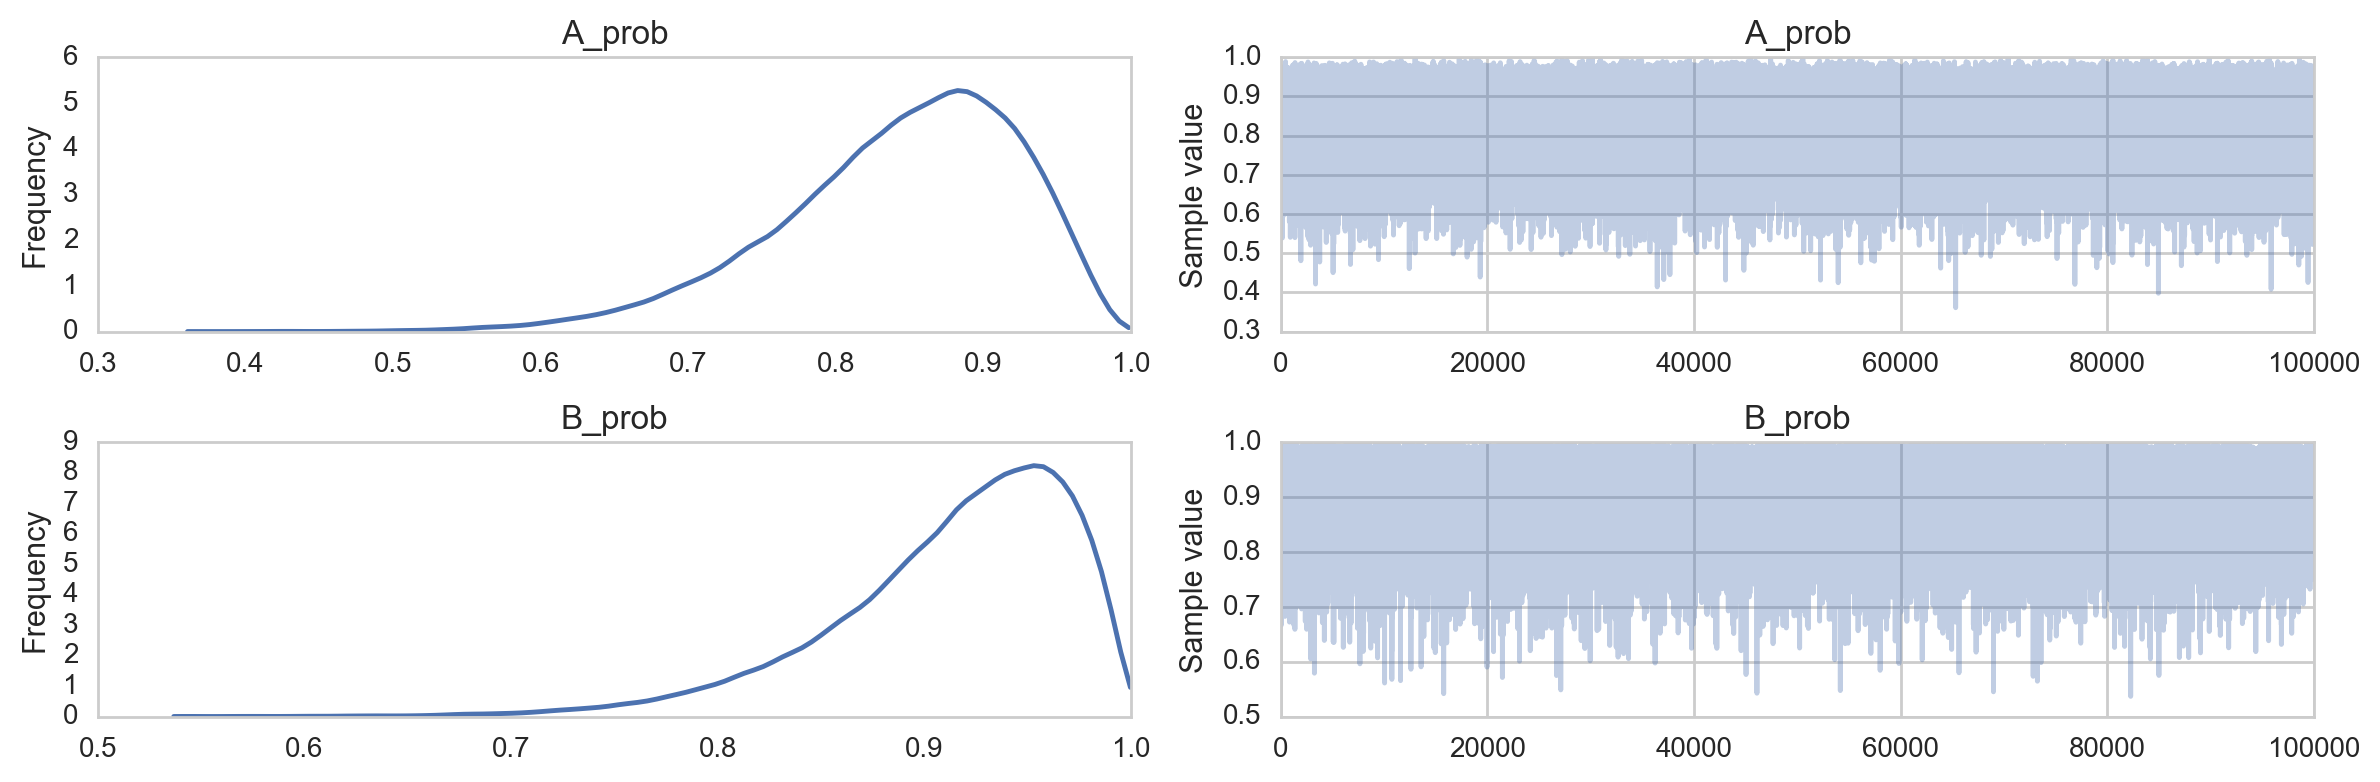

In [30]:
pm.traceplot(trace)

In [31]:
def plot_betas(beta_traces, beta_names, colors=['steelblue','darkred','goldenrod']):
    fig, ax = plt.subplots(figsize=(9,5))
    for i, bn in enumerate(beta_names):
        ax = sns.distplot(beta_traces[i], kde=True, color=colors[i], label=bn)
    ax.legend(loc='upper right')
    plt.show()

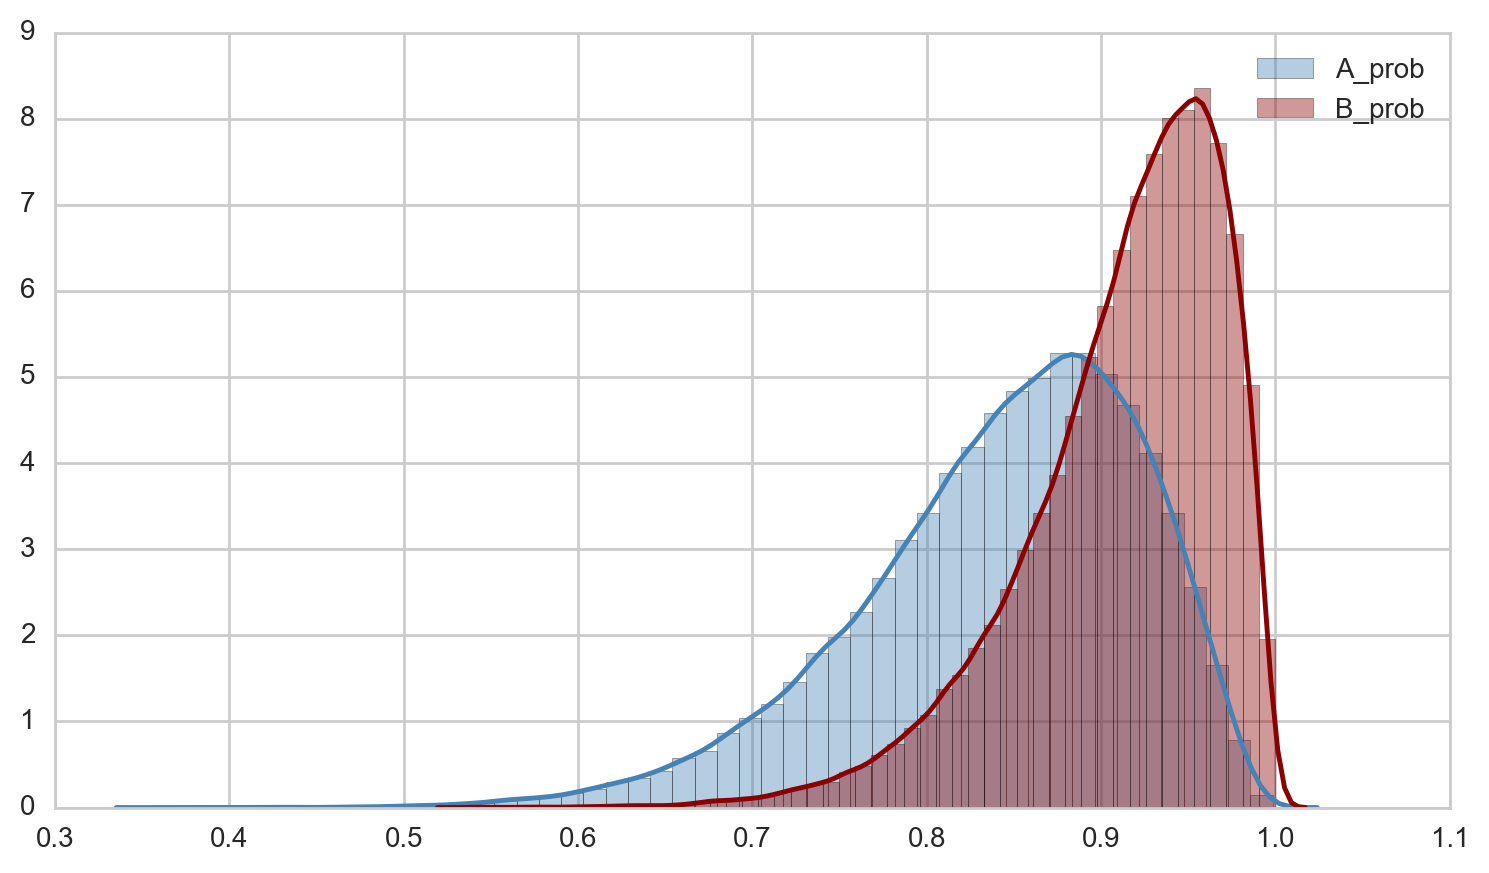

In [32]:
plot_betas([trace['A_prob'], trace['B_prob']], ['A_prob','B_prob'])